In [4]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt
from dolfin import *
import os
import copy

In [5]:
def GRF2d(Nx, Ny, alpha): ## alpha: Power spectrum decay parameter that controls the roughness/smoothness of the field
    # define wavenumber and coefficients
    kx = np.fft.fftfreq(Nx,1/Nx)  # wavenumbers  generates frequency components for FFT; The scaling 1/Nx and 1/Ny sets the frequency spacing
    ky = np.fft.rfftfreq(Ny,1/Ny) # wavenumbers  It is used for real FFT, giving only non-negative frequencies
    Kx,Ky = np.meshgrid(kx,ky)    # k = (kx,ky) wavevector in 2d: creates 2D arrays of wavenumbers
    K = np.sqrt(Kx**2+Ky**2).T    # wavenumber magnitude |k|

    #
    lmbda = (K+1)**(-alpha)    # decay parameters Creates a power-law decay factor; Higher alpha creates smoother fields; Adding 1 prevents division by zero at K=0
    # Change the mean and standard deviation

    eta = (
        np.random.randn(*K.shape) + 1j*np.random.randn(*K.shape)
    ) # random coefficients Creates complex random numbers; Real and imaginary parts are independently normally distributed; Shape matches the wavevector grid

    # Fourier coefficients of u; Multiplies random coefficients by decay factors; This shapes the power spectrum of the field
    uhat = lmbda * eta

    # transform back via inverse FT; irfft2 performs 2D inverse real FFT; Transforms from frequency domain back to spatial domain; norm='forward' specifies the normalization convention
    u = np.fft.irfft2(uhat, norm='forward')

    return u

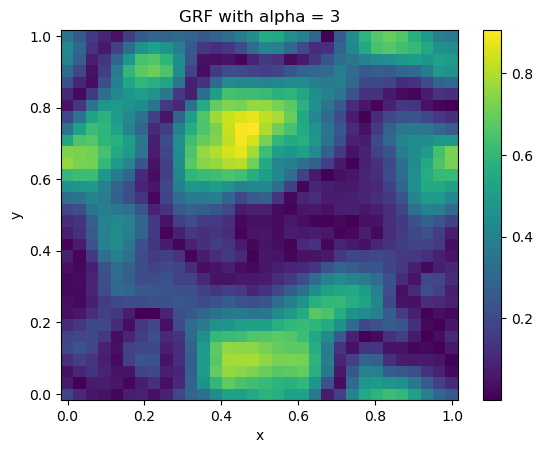

In [10]:
N = 32 
x = np.linspace(0,1,N)
X,Y = np.meshgrid(x,x)
alpha = 3
u = abs(GRF2d(N,N,alpha))
u_2 = copy.deepcopy(u)

# plot
plt.figure()
plt.pcolor(X,Y,u)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'GRF with alpha = {alpha}')
plt.show()

In [5]:
nx = ny = 128
mesh = RectangleMesh(Point(0, 0), Point(1, 1), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

def create_diffusion_coefficient(V):
    D = Function(V)
    d = D.vector()
    dof_coordinates = V.tabulate_dof_coordinates()

    x = dof_coordinates[:, 0]
    y = dof_coordinates[:, 1]
    
    grid_x = (x * N).astype(int)
    grid_y = (y * N).astype(int)

    grid_values = u

    for i in range(len(x)):
        if grid_x[i] >= N:
            grid_x[i] = N-1
        if grid_y[i] >= N:
            grid_y[i] = N-1
        d[i] = grid_values[grid_x[i], grid_y[i]]
    
    return D

D = create_diffusion_coefficient(V)
num_steps = 100
dt = 0.001
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0.0), boundary)

parameter = 1
x0, y0 = 0.5,0.5  
magnitude = 1
u_initial = Expression("magnitude*(1-exp(-1/((parameter*parameter*(x[0]-x0)*(x[0]-x0)+parameter*parameter*(x[1]-y0)*(x[1]-y0)))))", \
                    degree=2, magnitude=magnitude, parameter=parameter, x0=x0, y0=y0)
u_n = interpolate(u_initial, V)

u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.0)

a = u*v*dx + dt*D*inner(grad(u), grad(v))*dx + dt*inner(grad(u), grad(D))*v*dx - dt*inner(grad(D), grad(u))*v*dx
L = u_n*v*dx + dt*f*v*dx

u = Function(V)

output_dir = "GRF_gradD"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

vtkfile_u = File(f"{output_dir}/solution.pvd")
u.rename("u", "Solution")

t = 0
for n in range(num_steps):
    t += dt
    solve(a == L, u, bc)
    vtkfile_u << (u, t)
    u_n.assign(u)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

In [6]:
nx = ny = 128
mesh = RectangleMesh(Point(0, 0), Point(1, 1), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

num_steps = 100 
dt = 0.001

def create_diffusion_coefficient(V):
    D = Function(V)
    d = D.vector()

    dof_coordinates = V.tabulate_dof_coordinates()

    x = dof_coordinates[:, 0]
    y = dof_coordinates[:, 1]

    grid_x = (x * N).astype(int)
    grid_y = (y * N).astype(int)

    grid_values = u_2

    for i in range(len(x)):
        if grid_x[i] >= N:
            grid_x[i] = N-1
        if grid_y[i] >= N:
            grid_y[i] = N-1
        d[i] = grid_values[grid_x[i], grid_y[i]]
    
    return D

D = create_diffusion_coefficient(V)

parameter = 10
x0, y0 = 0.5,0.5
magnitude = 1
u_initial = Expression("magnitude*(1-exp(-1/((parameter*parameter*(x[0]-x0)*(x[0]-x0)+parameter*parameter*(x[1]-y0)*(x[1]-y0)))))", \
                    degree=2, magnitude=magnitude, parameter=parameter, x0=x0, y0=y0, domain=mesh)
u_n = interpolate(u_initial, V)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0.0), boundary)

parameter = 10
x0, y0 = 0.5,0.5
magnitude = 1
u_initial = Expression("magnitude*(1-exp(-1/((parameter*parameter*(x[0]-x0)*(x[0]-x0)+parameter*parameter*(x[1]-y0)*(x[1]-y0)))))", \
                    degree=2, magnitude=magnitude, parameter=parameter, x0=x0, y0=y0, domain=mesh)
u_n = interpolate(u_initial, V)

u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.0)

a = u*v*dx + dt*D*dot(grad(u), grad(v))*dx + dt*dot(grad(u), grad(D))*v*dx - dt*dot(grad(D), grad(u))*v*dx
L = u_n*v*dx + dt*f*v*dx

u = Function(V)
output_dir = "GRF_gradD_L"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

vtkfile_u = File(f"{output_dir}/solution.pvd")
u.rename("u", "Solution")

t = 0
for n in range(num_steps):
    t += dt
    solve(a == L, u, bc)
    vtkfile_u << (u, t)
    u_n.assign(u)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem